Transformer 모델 사용
<br> IMDb 영화 리뷰 데이터를 분석 -> 긍/부정 분류

In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
vocab_size = 20000  # 상위 20,000개의 단어만 사용
maxlen = 200  # 각 영화평의 길이를 200으로 맞춤

(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_test), "Test sequences")

x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

# IMDb 데이터셋 로드,  훈련 데이터와 테스트 데이터 세팅
# pad_sequences : 모든 리뷰의 길이를 동일하게



17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
25000 Training sequences
25000 Test sequences


In [3]:
#################
# 인코더 블록 정의
#################

from tensorflow.keras import layers

class EncoderBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):

        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()

        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


# MultiHeadAttention: 멀티헤드 어텐션 레이어
# ffn: 완전연결층(Feed Forward Network)
# LayerNormalization: 레이어 정규화
# Dropout: 드롭아웃 -> 과적합 방지

In [4]:
# 토큰 및 위치 임베딩 정의
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):

        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# Embedding: 단어 -> 임베딩 벡터로 변환
# pos_emb: 각 위치에 대한 임베딩 추가

In [6]:
# 모델 설계

embed_dim = 32  # 각 토큰의 임베딩 벡터 크기
num_heads = 2  # 어텐션 헤드의 수
ff_dim = 32  # 완전연결층의 노드 수

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
x = EncoderBlock(embed_dim, num_heads, ff_dim)(x, training=True)
x = EncoderBlock(embed_dim, num_heads, ff_dim)(x, training=True)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)


# TokenAndPositionEmbedding 레이어 사용 -> 입력 시퀀스 임베딩
# 두 개의 EncoderBlock -> 입력 시퀀스를 처리
# GlobalAveragePooling1D: 시퀀스의 평균
# Dense 레이어 + Dropout -> 모델 출력 생성


In [7]:
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding_3       │ (None, 200, 32)             │         646,400 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_block_4 (EncoderBlock)       │ (None, 200, 32)             │          10,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_block_5 (EncoderBlock)       │ (None, 200, 32)             │          10,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 20)                  │             660 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 2)                   │              42 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 668,414 (2.55 MB)

 Trainable params: 668,414 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

모델 컴파일 및 **학습**

In [8]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [10]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
checkpoint_filepath = './temp/checkpoint_en.weights.h5'
mc = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min',
                     save_weights_only=True, save_best_only=True)


# EarlyStopping:  학습 조기 종료
# ModelCheckpoint: 모델 가중치 저장


In [11]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

In [12]:
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [ ]:
history = model.fit(
    x_train, y_train_one_hot, batch_size=128, epochs=10, validation_split=0.1, callbacks=[es, mc]
)

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 185s 972ms/step - accuracy: 0.6294 - loss: 0.6152 - val_accuracy: 0.8864 - val_loss: 0.2896
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 199s 949ms/step - accuracy: 0.9214 - loss: 0.2166 - val_accuracy: 0.8868 - val_loss: 0.2848
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 198s 931ms/step - accuracy: 0.9704 - loss: 0.0991 - val_accuracy: 0.8788 - val_loss: 0.3477
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 197s 903ms/step - accuracy: 0.9888 - loss: 0.0434 - val_accuracy: 0.8668 - val_loss: 0.5016
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 212s 951ms/step - accuracy: 0.9944 - loss: 0.0232 - val_accuracy: 0.8740 - val_loss: 0.5375
Epoch 5: early stopping


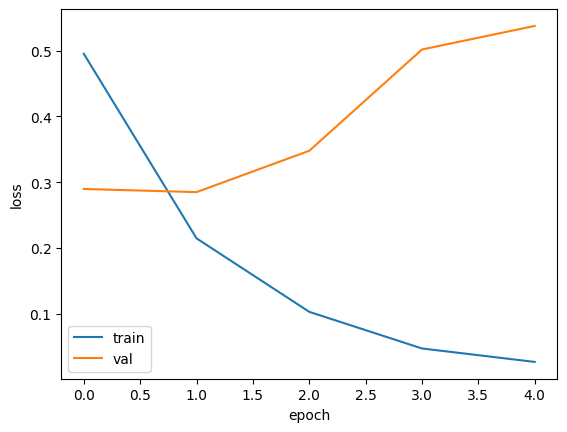

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
model.load_weights(checkpoint_filepath)

# 학습된 모델의 가중치 호출(from 파일) .... 검증 손실이 가장 낮은 지점에서 가중치가 저장된 파일
# ->  저장된 가중치를 사용하여 예측 수행 or 추가 학습



In [ ]:
test_loss, test_acc = model.evaluate(x_test,y_test_one_hot)

782/782 ━━━━━━━━━━━━━━━━━━━━ 67s 85ms/step - accuracy: 0.8678 - loss: 0.3255


In [ ]:
preds = model.predict(x_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 67s 85ms/step


In [ ]:
import numpy as np
labels=[0,1]
preds1 = [labels[np.argmax(probs)] for probs in preds]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds1))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87     12500
           1       0.90      0.83      0.86     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000

